# Metrics_Function

In [34]:
import pandas as pd
import glob
import os

def compute_metrics(folder: str, prefix: str) -> pd.DataFrame:
    """
    Compute accuracy, sufficiency, and similarities for all CSVs in a folder
    that start with the given prefix.
    
    Args:
        folder (str): Path to folder containing eval CSV files.
        prefix (str): Prefix of the filenames (e.g. 'eval_cohere_r_command_').
        
    Returns:
        pd.DataFrame: Summary table of metrics across versions.
    """
    files = sorted(glob.glob(os.path.join(folder, f"{prefix}*.csv")))
    results = []

    for f in files:
        version = os.path.splitext(os.path.basename(f))[0].split("_")[-1]
        df = pd.read_csv(f)

        # Accuracy with explanation
        acc_exp = df["is_correct_exp"].mean()

        # Accuracy without explanation (baseline)
        acc_noexp = df["is_correct_noexp"].mean() if "is_correct_noexp" in df else None

        # Sufficiency (mean prob of correct answer given explanation)
        suff = df["prob_exp"].mean()

        # Similarities (may not exist in baseline)
        sim = df["similarity_with_base"].mean() if "similarity_with_base" in df else None
        sim_clean = df["similarity_with_base_clean"].mean() if "similarity_with_base_clean" in df else None

        results.append({
            "version": version,
            "accuracy_exp": acc_exp,
            "accuracy_noexp": acc_noexp,
            "sufficiency": suff,
            "similarity": sim,
            "similarity_clean": sim_clean
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="version").reset_index(drop=True)
    return results_df


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def plot_metrics(results_df, model_name="Model"):
    """
    Create publication-ready plots for accuracy, sufficiency, and similarity metrics.
    Y-axis starts from 0 to avoid visual bias.
    
    Args:
        results_df (pd.DataFrame): Results dataframe with version and metric columns
        model_name (str): Name of the model for the title
    """
    results_df["version"] = results_df["version"].astype(int)
    baseline_df = results_df[results_df["version"] == 0]
    other_df = results_df[results_df["version"] != 0].sort_values(by="version", ascending=False)
    plot_df = pd.concat([baseline_df, other_df])
    
    # Define consistent styling
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    x_pos = range(len(plot_df))
    
    # Create figure with publication-ready dimensions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), facecolor='white')
    fig.patch.set_facecolor('white')
    
    # Color scheme for consistency
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Accuracy
    axs[0].plot(x_pos, plot_df["accuracy_exp"], marker="o", linewidth=2.5, 
                markersize=8, color=colors[0], label="With Explanation", zorder=3)
    if "accuracy_noexp" in plot_df.columns:
        axs[0].plot(x_pos, plot_df["accuracy_noexp"], marker="s", linewidth=2.5, 
                    markersize=8, linestyle="--", color=colors[1], 
                    label="Without Explanation", zorder=3)
    
    axs[0].set_title("Model Accuracy", fontsize=14, fontweight='bold', pad=15)
    axs[0].set_ylabel("Accuracy Score", fontsize=12)
    axs[0].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
    axs[0].set_ylim(0, 1.0)  # Start from 0, max at 1.0 for accuracy
    
    # Plot 2: Sufficiency
    axs[1].plot(x_pos, plot_df["sufficiency"], marker="^", linewidth=2.5, 
                markersize=8, color=colors[2], zorder=3)
    axs[1].set_title("Explanation Sufficiency", fontsize=14, fontweight='bold', pad=15)
    axs[1].set_ylabel("Sufficiency Score", fontsize=12)
    axs[1].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[1].set_ylim(0, 1.0)  # Start from 0, max at 1.0 for sufficiency
    
    # Plot 3: Similarity
    if "similarity" in plot_df.columns:
        axs[2].plot(x_pos, plot_df["similarity"], marker="o", linewidth=2.5, 
                    markersize=8, color='#C73E1D', label="Original", zorder=3)
    if "similarity_clean" in plot_df.columns:
        axs[2].plot(x_pos, plot_df["similarity_clean"], marker="^", linewidth=2.5, 
                    markersize=8, color='#7209B7', label="Cleaned", zorder=3)
    
    axs[2].set_title("Output Similarity", fontsize=14, fontweight='bold', pad=15)
    axs[2].set_ylabel("Similarity Score", fontsize=12)
    axs[2].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[2].legend(frameon=True, fancybox=True, shadow=True, loc='best')
    axs[2].set_ylim(0, 1.0)  # Start from 0, max at 1.0 for similarity
    
    # Common styling for all subplots
    for i, ax in enumerate(axs):
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels, rotation=45, ha='right', fontsize=11)
        ax.set_xlabel("Constraint Level", fontsize=12, fontweight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.8)
        ax.spines['bottom'].set_linewidth(0.8)
        
        # Add subtle background shading for baseline
        ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=1)
    
    # Main title
    fig.suptitle(f"Performance Metrics Evaluation: {model_name}", 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)
    plt.show()


def plot_multi_models(dfs: dict, metric: str, title: str, save_path=None):
    """
    Create publication-ready multi-model comparison plot.
    Y-axis starts from 0 to avoid visual bias.
    
    Args:
        dfs (dict): Dictionary of model names and their dataframes
        metric (str): Metric column name to plot
        title (str): Plot title
        save_path (str, optional): Path to save the figure
    """
    # Create publication-ready figure
    plt.figure(figsize=(12, 7), facecolor='white')
    
    # Enhanced color palette for multiple models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Line styles for variety
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for i, (model_name, df) in enumerate(dfs.items()):
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        x_pos = range(len(plot_df))
        
        plt.plot(x_pos, plot_df[metric], 
                marker=markers[i % len(markers)], 
                linewidth=3, 
                markersize=9,
                color=colors[i % len(colors)],
                linestyle=line_styles[i % len(line_styles)],
                label=model_name,
                zorder=3)
    
    # Styling
    plt.xticks(x_pos, display_labels, rotation=45, ha='right', fontsize=12)
    plt.ylabel(f"{metric.replace('_', ' ').title()} Score", fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Set y-axis to start from 0
    plt.ylim(0, 1.0)  # Start from 0, max at 1.0 for most metrics
    
    # Enhanced legend
    plt.legend(frameon=True, fancybox=True, shadow=True, 
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
    
    # Grid and styling
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # Highlight baseline region
    plt.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=1)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12, right=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    plt.show()

In [57]:
def plot_heatmap_comparison(dfs: dict, metrics: list, title: str = "Model Performance Heatmap"):
    """
    Create a heatmap comparison of multiple metrics across models and constraint levels.
    
    Args:
        dfs (dict): Dictionary of model names and their dataframes
        metrics (list): List of metric column names
        title (str): Heatmap title
    """
    # Prepare data for heatmap
    heatmap_data = []
    model_names = []
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for model_name, df in dfs.items():
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        for metric in metrics:
            if metric in plot_df.columns:
                heatmap_data.append(plot_df[metric].values)
                model_names.append(f"{model_name} - {metric.replace('_', ' ').title()}")
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, len(model_names) * 0.6), facecolor='white')
    
    heatmap_array = np.array(heatmap_data)
    
    # Set proper color range from 0 to 1 for consistency
    im = ax.imshow(heatmap_array, cmap='RdYlGn', aspect='auto', interpolation='nearest', vmin=0, vmax=1)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Performance Score', fontsize=12, fontweight='bold')
    
    # Labels
    ax.set_xticks(range(len(display_labels)))
    ax.set_xticklabels(display_labels, rotation=45, ha='right')
    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names, fontsize=10)
    
    ax.set_xlabel("Constraint Level", fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add value annotations
    for i in range(len(model_names)):
        for j in range(len(display_labels)):
            text = ax.text(j, i, f'{heatmap_array[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Claude

In [13]:
claude_df = compute_metrics("claude", "eval_claude_3_haiku_")
claude_df

,version,accuracy_exp,sufficiency,similarity,similarity_clean
0,0,0.862069,0.929116,NaN,NaN
1,10,0.828749,0.887981,0.661400,0.669648
2,20,0.831461,0.900159,0.754894,0.762059
3,30,0.848508,0.909141,0.805928,0.812099
4,40,0.846959,0.915361,0.831252,0.837705
5,50,0.852383,0.917220,0.841518,0.848386
6,60,0.854707,0.921090,0.850156,0.857235
7,70,0.855870,0.919569,0.857712,0.864955
8,80,0.853158,0.921072,0.865163,0.872693
9,90,0.857032,0.922947,0.872764,0.880185


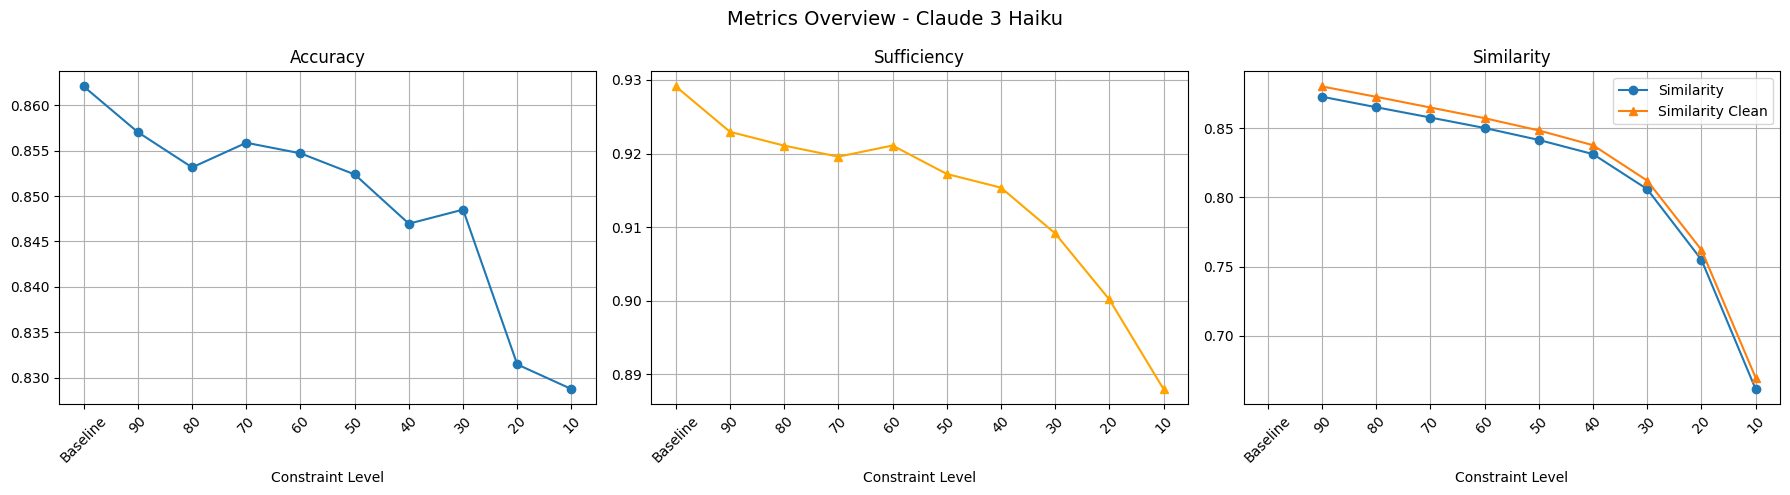

In [23]:
plot_metrics(claude_df, model_name="Claude 3 Haiku")

## GPT

In [15]:
gpt_df = compute_metrics("gpt_4o_mini", "eval_gpt_4o_mini_")
gpt_df

,version,accuracy_exp,sufficiency,similarity,similarity_clean
0,0,0.893452,0.936555,NaN,NaN
1,10,0.832623,0.882047,0.615903,0.623687
2,20,0.852383,0.897906,0.702027,0.711257
3,30,0.862844,0.906248,0.762681,0.772458
4,40,0.873692,0.913374,0.806133,0.815740
5,50,0.876404,0.918724,0.835769,0.845480
6,60,0.880279,0.922208,0.857652,0.867835
7,70,0.890740,0.927384,0.875391,0.886075
8,80,0.893065,0.933008,0.889263,0.899271
9,90,0.892290,0.932254,0.898990,0.909736


## Cohere

In [14]:
cohere_df = compute_metrics("cohere", "eval_cohere_r_command_")
cohere_df

,version,accuracy_exp,sufficiency,similarity,similarity_clean
0,0,0.850058,0.926907,NaN,NaN
1,10,0.795816,0.863648,0.589759,0.593725
2,20,0.807439,0.876703,0.682581,0.684795
3,30,0.811313,0.883617,0.722988,0.726150
4,40,0.812863,0.886484,0.751572,0.755322
5,50,0.816738,0.889679,0.775333,0.779007
6,60,0.818287,0.892342,0.794160,0.798540
7,70,0.825262,0.897821,0.811670,0.816446
8,80,0.830686,0.899546,0.825693,0.830384
9,90,0.831461,0.904703,0.837877,0.842754


## LLama

In [16]:
llama_df = compute_metrics("llama", "eval_llama_4_maverik_")
llama_df

,version,accuracy_exp,sufficiency,similarity,similarity_clean
0,0,0.918636,0.934367,NaN,NaN
1,10,0.831848,0.868946,0.597881,0.604056
2,20,0.848508,0.884973,0.694098,0.704760
3,30,0.859744,0.894504,0.748862,0.760657
4,40,0.877567,0.903462,0.783669,0.796235
5,50,0.884153,0.908620,0.805946,0.818998
6,60,0.891902,0.912491,0.823152,0.836979
7,70,0.898876,0.918394,0.836293,0.850958
8,80,0.899651,0.920364,0.846000,0.860623
9,90,0.900814,0.924066,0.855688,0.871208


## Deepseek

In [17]:
deepseek_df = compute_metrics("deepseek", "eval_deepseek_v3.1_")
deepseek_df

,version,accuracy_exp,sufficiency,similarity,similarity_clean
0,0,0.907400,0.932211,NaN,NaN
1,10,0.841147,0.877245,0.597951,0.607101
2,20,0.862069,0.888956,0.665568,0.677204
3,30,0.869430,0.897447,0.710050,0.721974
4,40,0.883766,0.899457,0.742446,0.755558
5,50,0.886478,0.907098,0.765120,0.778337
6,60,0.889578,0.911561,0.784053,0.797486
7,70,0.896939,0.914024,0.798638,0.811979
8,80,0.898102,0.918671,0.811059,0.825409
9,90,0.901201,0.922241,0.827297,0.840714


## Gemini

In [18]:
gemini_df = compute_metrics("gemini", "eval_gemini_2.0_flash_")
gemini_df

,version,accuracy_exp,sufficiency,similarity,similarity_clean
0,0,0.897714,0.921843,NaN,NaN
1,10,0.822937,0.874734,0.642088,0.647249
2,20,0.855482,0.897178,0.738644,0.744572
3,30,0.876792,0.905614,0.792207,0.798056
4,40,0.887253,0.914325,0.825845,0.831884
5,50,0.887640,0.917870,0.848825,0.854730
6,60,0.888415,0.920079,0.862534,0.868196
7,70,0.895777,0.921853,0.872262,0.877988
8,80,0.901976,0.923030,0.878374,0.884315
9,90,0.902363,0.926663,0.884798,0.890757


## Mistral

In [19]:
mistral_df = compute_metrics("mistral", "eval_mistral_small_3.1_")
mistral_df

,version,accuracy_exp,sufficiency,similarity,similarity_clean
0,0,0.900039,0.930864,NaN,NaN
1,10,0.813251,0.868611,0.596492,0.606380
2,20,0.830686,0.882736,0.669407,0.683690
3,30,0.845021,0.890096,0.711986,0.728163
4,40,0.857807,0.894301,0.747910,0.764041
5,50,0.849283,0.899337,0.772484,0.790051
6,60,0.861682,0.902613,0.791830,0.809810
7,70,0.865556,0.907638,0.805617,0.824267
8,80,0.866718,0.909720,0.815906,0.834726
9,90,0.864394,0.910208,0.828148,0.847396


# Multi_Models

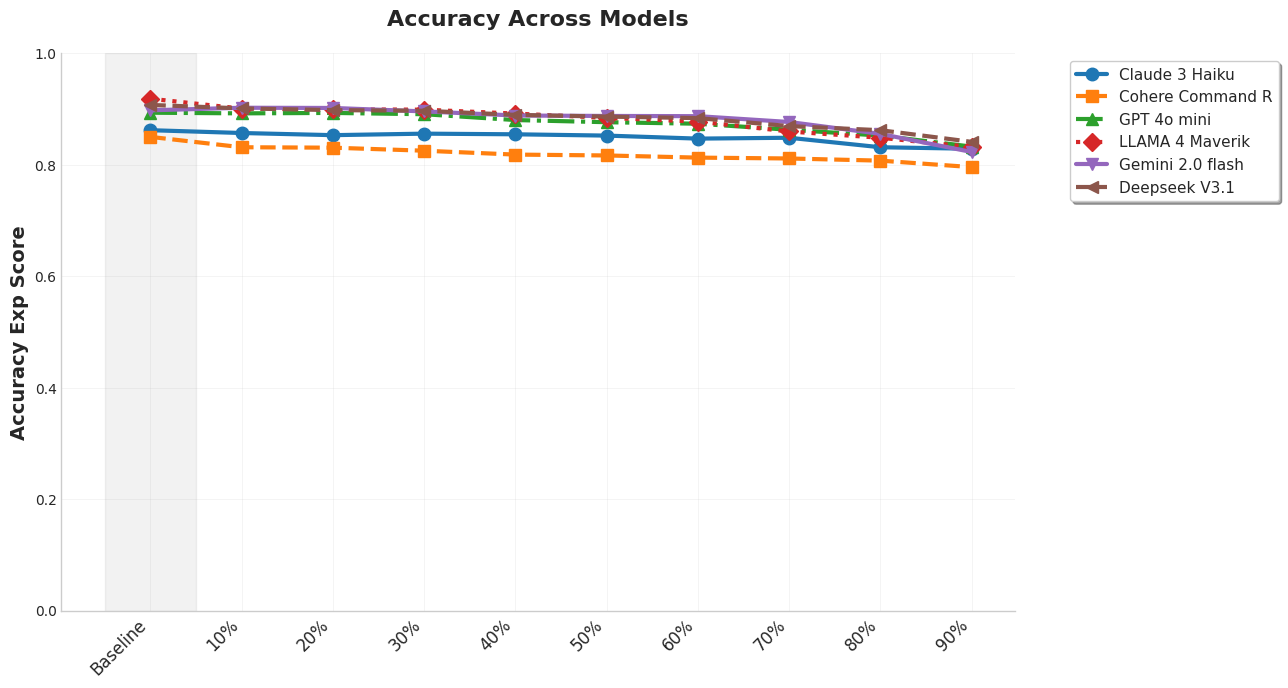

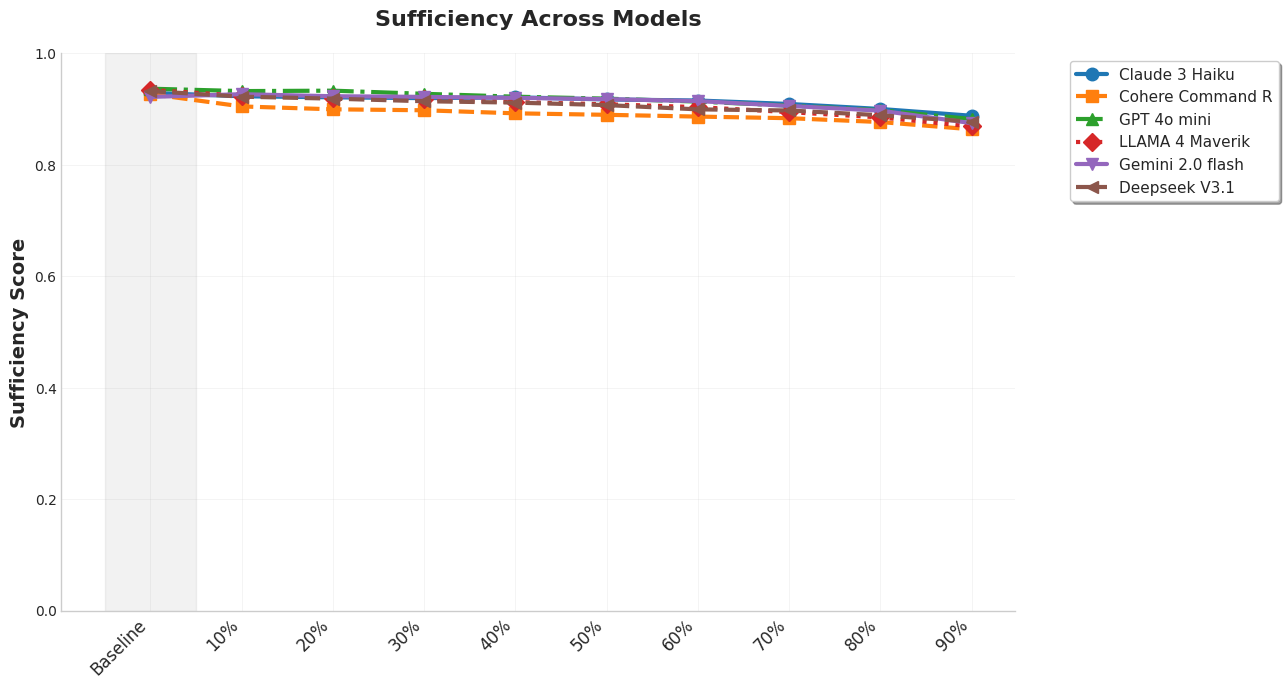

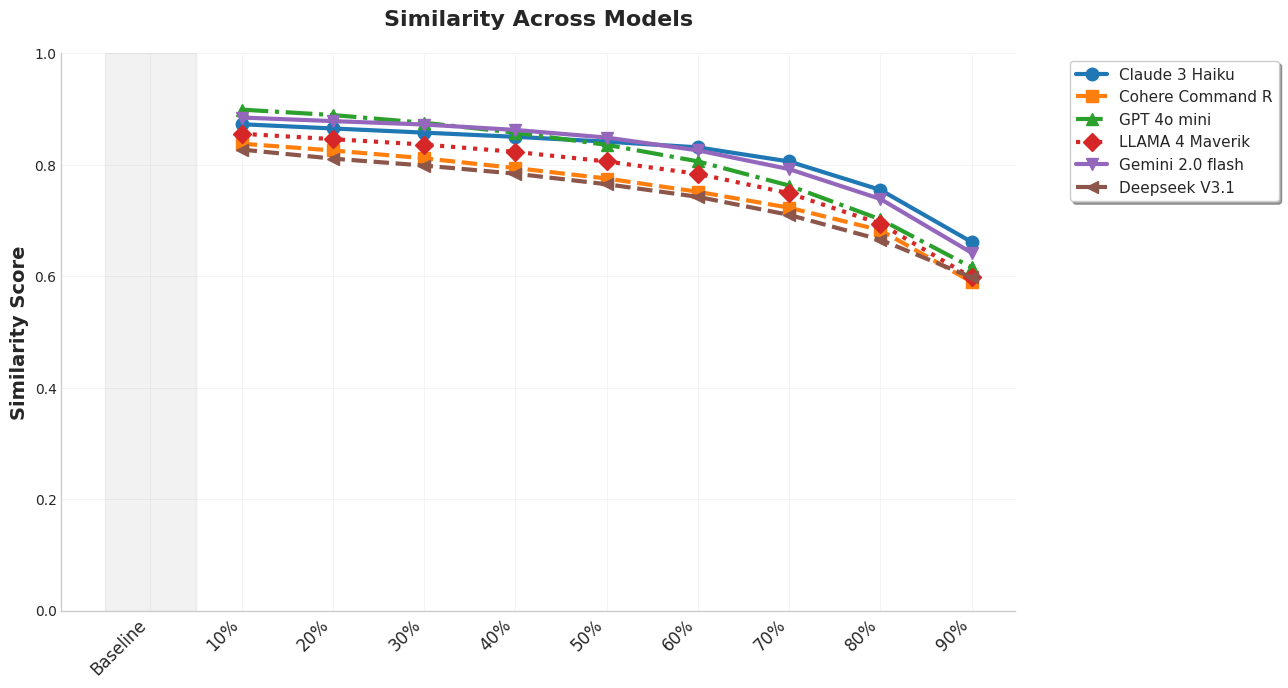

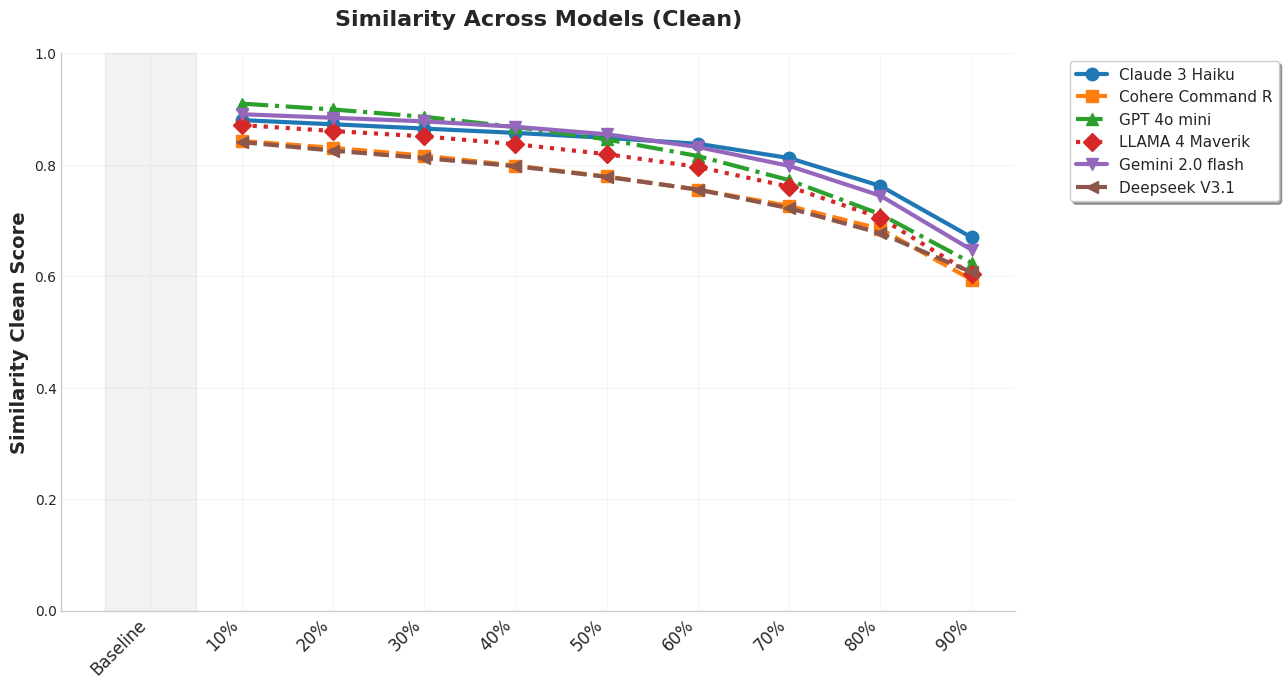

In [56]:
# دیکشنری از مدل‌ها
dfs = {
    "Claude 3 Haiku": claude_df,
    "Cohere Command R": cohere_df,
    "GPT 4o mini": gpt_df,
    "LLAMA 4 Maverik": llama_df,
    "Gemini 2.0 flash": gemini_df,
    "Deepseek V3.1": deepseek_df,
}

# Accuracy
plot_multi_models(dfs, "accuracy_exp", "Accuracy Across Models")

# Sufficiency
plot_multi_models(dfs, "sufficiency", "Sufficiency Across Models")

# Similarity
plot_multi_models(dfs, "similarity", "Similarity Across Models")

# Similarity Clean
plot_multi_models(dfs, "similarity_clean", "Similarity Across Models (Clean)")

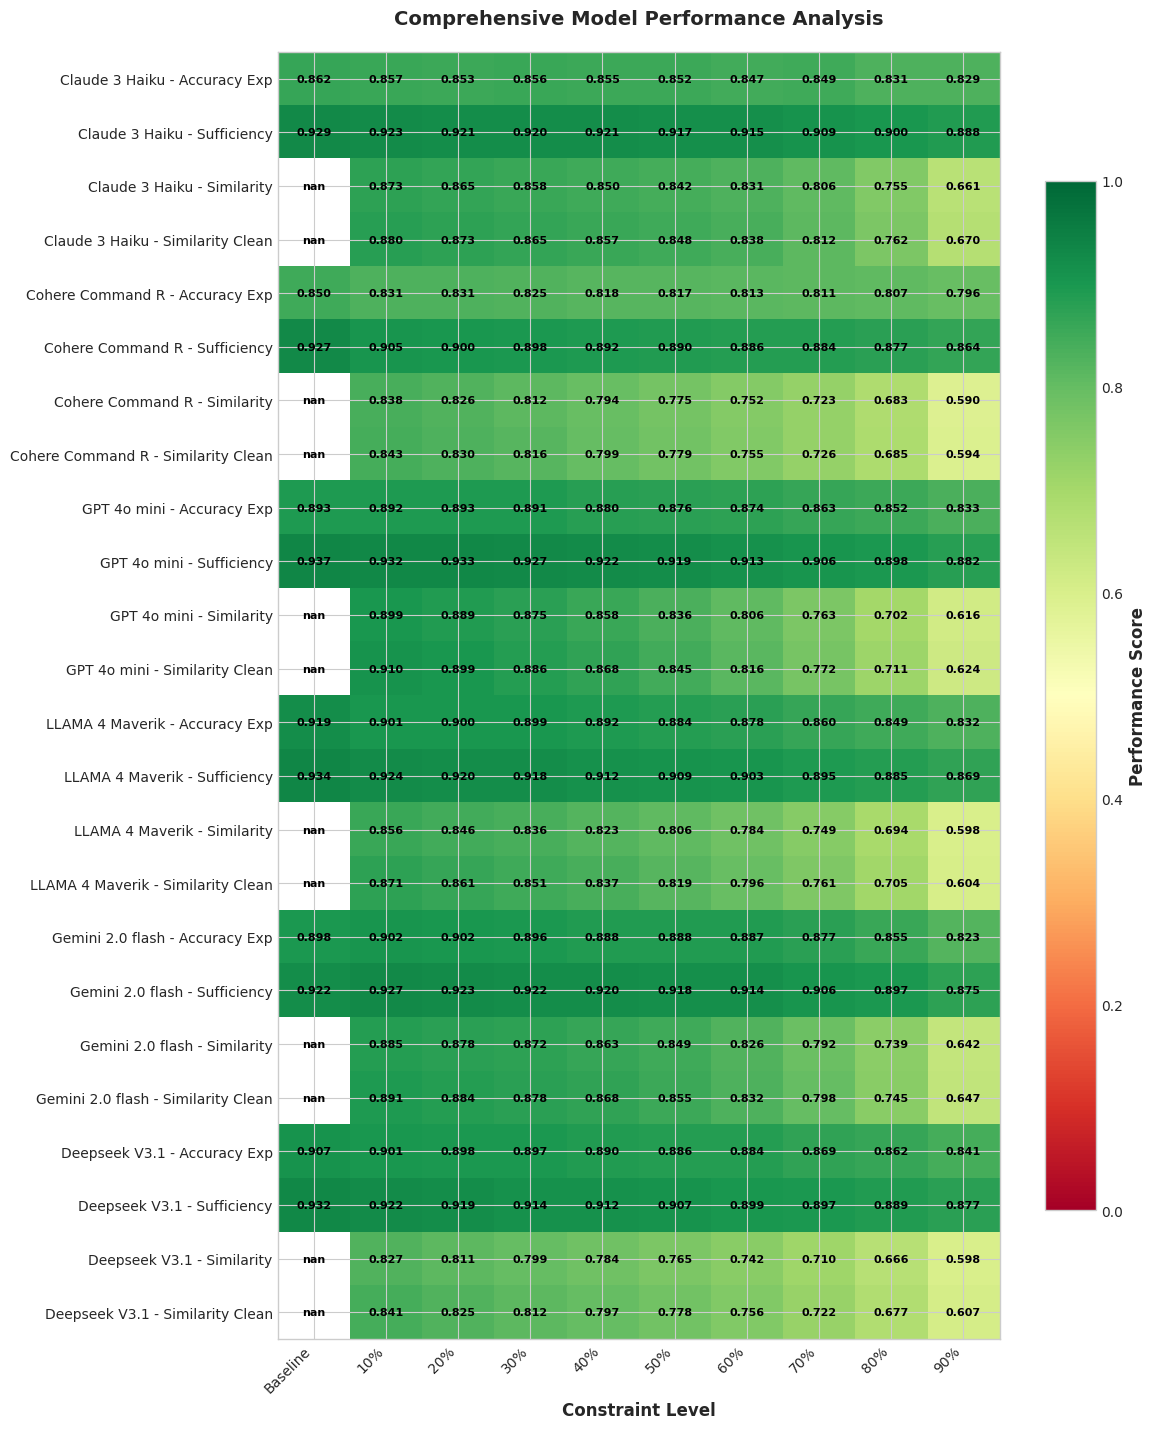

In [59]:
# Example 3: All available metrics
all_metrics = ["accuracy_exp", "accuracy_noexp", "sufficiency", "similarity", "similarity_clean"]
plot_heatmap_comparison(dfs, all_metrics, 
                       title="Comprehensive Model Performance Analysis")

# Other Visualization

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Set professional style
plt.style.use('default')
sns.set_palette("Set2")

def plot_grouped_comparison(dfs: dict, metrics: list, title: str = "Model Performance Comparison"):
    """
    Create a clean grouped bar chart comparison across models and metrics.
    """
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    # Prepare data
    n_models = len(dfs)
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 8), facecolor='white')
    if n_metrics == 1:
        axes = [axes]
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#2CA02C']
    
    for metric_idx, metric in enumerate(metrics):
        ax = axes[metric_idx]
        
        # Calculate bar positions
        bar_width = 0.8 / n_models
        x_pos = np.arange(len(display_labels))
        
        for model_idx, (model_name, df) in enumerate(dfs.items()):
            df = df.copy()
            df["version"] = df["version"].astype(int)
            baseline_df = df[df["version"] == 0]
            other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
            plot_df = pd.concat([baseline_df, other_df])
            
            if metric in plot_df.columns:
                values = plot_df[metric].values
                bar_positions = x_pos + (model_idx - n_models/2 + 0.5) * bar_width
                
                bars = ax.bar(bar_positions, values, bar_width, 
                             label=model_name, color=colors[model_idx % len(colors)],
                             alpha=0.8, edgecolor='white', linewidth=1)
                
                # Add value labels on bars
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                           f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_title(f"{metric.replace('_', ' ').title()}", fontsize=14, fontweight='bold', pad=20)
        ax.set_ylabel("Performance Score", fontsize=12)
        ax.set_xlabel("Constraint Level", fontsize=12)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Highlight baseline
        ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=0)
        
        if metric_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, right=0.85)
    plt.show()


def plot_radar_comparison(dfs: dict, constraint_level: str = "50%", title: str = "Model Performance Radar"):
    """
    Create a radar chart comparing models at a specific constraint level.
    """
    # Map constraint level to version
    constraint_map = {"Baseline": 0, "10%": 10, "20%": 20, "30%": 30, "40%": 40, 
                     "50%": 50, "60%": 60, "70%": 70, "80%": 80, "90%": 90}
    
    version = constraint_map.get(constraint_level, 50)
    
    # Prepare data for radar chart
    metrics = ["accuracy_exp", "sufficiency", "similarity"]
    metric_labels = ["Accuracy", "Sufficiency", "Similarity"]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'), facecolor='white')
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#2CA02C']
    
    for i, (model_name, df) in enumerate(dfs.items()):
        df = df.copy()
        df["version"] = df["version"].astype(int)
        
        # Get data for specific constraint level
        model_data = df[df["version"] == version]
        if model_data.empty:
            continue
            
        values = []
        for metric in metrics:
            if metric in model_data.columns:
                values.append(model_data[metric].iloc[0])
            else:
                values.append(0)
        
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=3, label=model_name, 
                color=colors[i % len(colors)], markersize=8)
        ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=11)
    plt.title(f"{title} at {constraint_level} Constraint Level", 
              fontsize=14, fontweight='bold', pad=30)
    
    plt.tight_layout()
    plt.show()


def plot_performance_trends(dfs: dict, save_path: str = None):
    """
    Create an advanced multi-panel performance trends visualization.
    """
    metrics = ["accuracy_exp", "sufficiency", "similarity"]
    metric_titles = ["Model Accuracy", "Explanation Sufficiency", "Output Similarity"]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), facecolor='white')
    fig.patch.set_facecolor('white')
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    # Plot individual metrics
    for metric_idx, (metric, metric_title) in enumerate(zip(metrics, metric_titles)):
        if metric_idx < 3:
            row, col = metric_idx // 2, metric_idx % 2
            ax = axes[row, col]
            
            for model_idx, (model_name, df) in enumerate(dfs.items()):
                df = df.copy()
                df["version"] = df["version"].astype(int)
                baseline_df = df[df["version"] == 0]
                other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
                plot_df = pd.concat([baseline_df, other_df])
                
                if metric in plot_df.columns:
                    x_pos = range(len(plot_df))
                    ax.plot(x_pos, plot_df[metric], 
                           marker=markers[model_idx % len(markers)], 
                           linewidth=3, markersize=8,
                           color=colors[model_idx % len(colors)],
                           label=model_name if metric_idx == 0 else "")
            
            ax.set_title(metric_title, fontsize=14, fontweight='bold')
            ax.set_ylabel("Score", fontsize=12)
            ax.set_xlabel("Constraint Level", fontsize=12)
            ax.set_xticks(range(len(display_labels)))
            ax.set_xticklabels(display_labels, rotation=45, ha='right')
            ax.grid(True, alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Highlight baseline
            ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=0)
    
    # Combined performance score in the fourth subplot
    ax = axes[1, 1]
    for model_idx, (model_name, df) in enumerate(dfs.items()):
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        # Calculate combined score (average of available metrics)
        combined_scores = []
        for _, row in plot_df.iterrows():
            scores = []
            for metric in metrics:
                if metric in plot_df.columns and not pd.isna(row[metric]):
                    scores.append(row[metric])
            combined_scores.append(np.mean(scores) if scores else 0)
        
        x_pos = range(len(plot_df))
        ax.plot(x_pos, combined_scores, 
               marker=markers[model_idx % len(markers)], 
               linewidth=3, markersize=8,
               color=colors[model_idx % len(colors)],
               label=model_name)
    
    ax.set_title("Combined Performance Score", fontsize=14, fontweight='bold')
    ax.set_ylabel("Average Score", fontsize=12)
    ax.set_xlabel("Constraint Level", fontsize=12)
    ax.set_xticks(range(len(display_labels)))
    ax.set_xticklabels(display_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=0)
    
    # Add legend to the first subplot
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    fig.suptitle("Comprehensive Model Performance Analysis", 
                 fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, right=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    plt.show()


def plot_delta_heatmap(dfs: dict, baseline_metric: str = "accuracy_exp", title: str = "Performance Change from Baseline"):
    """
    Create a heatmap showing performance changes relative to baseline.
    """
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    
    delta_data = []
    model_names = list(dfs.keys())
    constraint_levels = ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for model_name, df in dfs.items():
        df = df.copy()
        df["version"] = df["version"].astype(int)
        
        baseline_value = df[df["version"] == 0][baseline_metric].iloc[0]
        
        model_deltas = []
        for version in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
            constraint_value = df[df["version"] == version][baseline_metric].iloc[0]
            delta = constraint_value - baseline_value
            model_deltas.append(delta)
        
        delta_data.append(model_deltas)
    
    delta_array = np.array(delta_data)
    
    # Create heatmap
    im = ax.imshow(delta_array, cmap='RdBu_r', aspect='auto', vmin=-0.1, vmax=0.1)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Performance Change from Baseline', fontsize=12, fontweight='bold')
    
    # Labels
    ax.set_xticks(range(len(constraint_levels)))
    ax.set_xticklabels(constraint_levels)
    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names, fontsize=12)
    
    ax.set_xlabel("Constraint Level", fontsize=14, fontweight='bold')
    ax.set_ylabel("Models", fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Add value annotations
    for i in range(len(model_names)):
        for j in range(len(constraint_levels)):
            value = delta_array[i, j]
            color = 'white' if abs(value) > 0.05 else 'black'
            ax.text(j, i, f'{value:+.3f}', ha="center", va="center", 
                   color=color, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()